<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [1]:
#@title imports / get data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-11-06 01:51:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2019-11-06 01:51:04 (279 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



## inspect / clean / prep data

In [2]:
!head house-votes-84.data;echo;tail house-votes-84.data

republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y
democrat,n,y,n,y,y,y,n,n,n,n,n,n,?,y,y,y
republican,n,y,n,y,y,y,n,n,n,n,n,n,y,y,?,y
republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
democrat,y,y,y,n,n,n,y,y,y,n,n,n,n,n,?,?

democrat,n,n,y,n,n,n,y,y,n,y,y,n,n,n,y,?
democrat,y,n,y,n,n,n,y,y,y,y,n,n,n,n,y,y
republican,n,n,n,y,y,y,y,y,n,y,n,y,y,y,n,y
democrat,?,?,?,n,n,n,y,y,y,y,n,n,y,n,y,y
democrat,y,n,y,n,?,n,y,y,y,y,n,y,n,?,y,y
republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
republican,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y
republican,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y
republican,n,y,n,y,y,y,n,n,n,y,n,y,y,y,?,n


In [3]:
house_votes_columns = ['party', 'handicapped-infants', 'water-project-cost-sharing', 'adoption-of-the-budget-resolution', 
                       'physician-fee-freeze', 'el-salvador-aid', 'religious-groups-in-schools', 'anti-satellite-test-ban',
                       'aid-to-nicaraguan-contras', 'mx-missile', 'immigration', 'synfuels-corporation-cutback',
                       'education-spending', 'superfund-right-to-sue', 'crime', 'duty-free-exports', 'export-administration-act-south-africa']
df = pd.read_csv('house-votes-84.data', header=None, names=house_votes_columns, na_values='?')
print(df.shape)
df

(435, 17)


,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
431,democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
432,republican,n,NaN,n,y,y,y,n,n,n,n,y,y,y,y,n,y
433,republican,n,n,n,y,y,y,NaN,NaN,NaN,NaN,n,y,y,y,n,y


In [4]:
df = df.replace({'y':1.0, 'n':0.0})
df

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,republican,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
431,democrat,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
432,republican,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
433,republican,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0


In [5]:
sorted(df['party'].unique())

['democrat', 'republican']

In [6]:
df_pivot = pd.pivot_table(df, index='party', aggfunc='mean')
df_pivot

,adoption-of-the-budget-resolution,aid-to-nicaraguan-contras,anti-satellite-test-ban,crime,duty-free-exports,education-spending,el-salvador-aid,export-administration-act-south-africa,handicapped-infants,immigration,mx-missile,physician-fee-freeze,religious-groups-in-schools,superfund-right-to-sue,synfuels-corporation-cutback,water-project-cost-sharing
party,,,,,,,,,,,,,,,,
democrat,0.888462,0.828897,0.772201,0.350195,0.637450,0.144578,0.215686,0.935135,0.604651,0.471483,0.758065,0.054054,0.476744,0.289683,0.505882,0.502092
republican,0.134146,0.152866,0.240741,0.981366,0.089744,0.870968,0.951515,0.657534,0.187879,0.557576,0.115152,0.987879,0.897590,0.860759,0.132075,0.506757


In [7]:
df_pivot_transpose = df_pivot.T
df_pivot_transpose

party,democrat,republican
adoption-of-the-budget-resolution,0.888462,0.134146
aid-to-nicaraguan-contras,0.828897,0.152866
anti-satellite-test-ban,0.772201,0.240741
crime,0.350195,0.981366
duty-free-exports,0.637450,0.089744
education-spending,0.144578,0.870968
el-salvador-aid,0.215686,0.951515
export-administration-act-south-africa,0.935135,0.657534
handicapped-infants,0.604651,0.187879
immigration,0.471483,0.557576


In [8]:
republicans = df[df['party']=='republican']
print(republicans.shape)
republicans

(168, 17)


,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,republican,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
430,republican,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
432,republican,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
433,republican,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0


In [9]:
democrats = df[df['party']=='democrat']
print(democrats.shape)
democrats

(267, 17)


,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,democrat,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN
426,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
428,democrat,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
429,democrat,1.0,0.0,1.0,0.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,1.0,1.0


## Confidence intervals

confidence interval = $\bar{x} \pm t \frac{s}{\sqrt{n}}$

standard error = $\frac{s}{\sqrt{n}}$

margin of error = $t\frac{s}{\sqrt{n}}$

$\bar{x}$ = sample mean

$t$ = t-statistic ??what does this mean?? - from running a ttest, i think

$s$ = sample standard deviation

$n$ = number of samples

In [0]:
def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = barx = np.mean(data)
  n = len(data)
  std_error = np.std(data, ddof=1) / np.sqrt(n) # ddof = delta degrees of freedom (len data - x)
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1) # searching for t-statistic that has 2.25% on each side which totals 5% which matches our 95% confidence level
  margin_of_error = t * std_error
  return mean, mean - margin_of_error, mean + margin_of_error

In [11]:
(1+.95)/2.0

0.975

In [12]:
testit=[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]
test_mean, test_lower_bound, test_upper_bound = confidence_interval(testit)
print('mean:', test_mean)
print('lower bound:', test_lower_bound)
print('upper bound:', test_upper_bound)
# yay, matches lecture notebook

mean: 0.6
lower bound: 0.5023039108049319
upper bound: 0.6976960891950681


### 1. Generate and numerically represent a confidence interval

In [13]:
# pick a column, remove NaNs
data = republicans['mx-missile'][~republicans['mx-missile'].isna()]

mean, lower_bound, upper_bound = confidence_interval(data, 0.99)
#print('lower bound:', lower_bound)
print('mean:', mean)
#print('upper bound:', upper_bound)
#print(lower_bound, '<', mean, '<', upper_bound)
#print((lower_bound, mean, upper_bound))
print('99% confidence interval:', (lower_bound, upper_bound))

mean: 0.11515151515151516
99% confidence interval: (0.05019166432092807, 0.18011136598210226)


### 2. Graphically (with a plot) represent the confidence interval

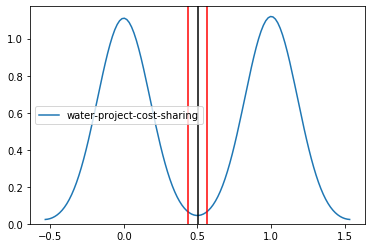

In [14]:
# pick a column, remove NaNs
# picked water project cause it was about 50/50 split on votes so the graph would look cooler
graph_data = democrats['water-project-cost-sharing'][~democrats['water-project-cost-sharing'].isna()]

# get confidence interval
graph_mean, graph_lower_bound, graph_upper_bound = confidence_interval(graph_data, 0.95)

# graph it
ax = sns.kdeplot(graph_data)
lb = plt.axvline(graph_lower_bound, color='red')
mn = plt.axvline(graph_mean, color='black')
ub = plt.axvline(graph_upper_bound, color='red')
#plt.legend([ax,lb,mn,ub], ['democrat votes on water project', 'lowerbound', 'mean', 'upperbound'])
plt.show()

# no ideaa how to choose a graph that explains what is going on

No handles with labels found to put in legend.


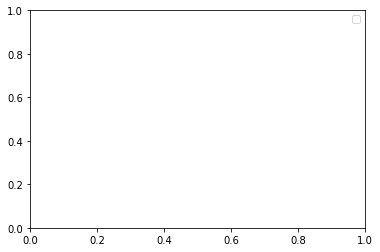

In [15]:
plt.legend()

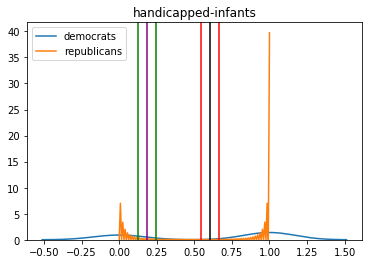

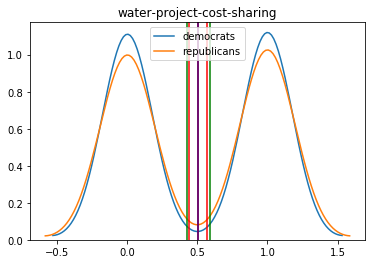

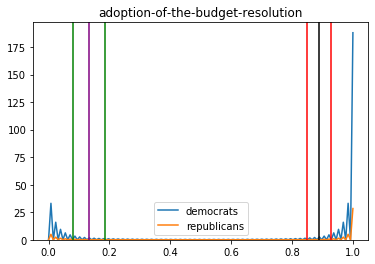

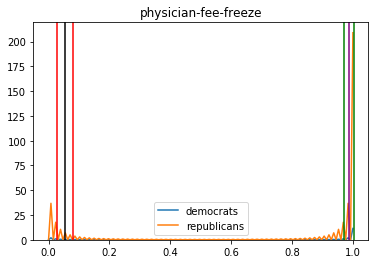

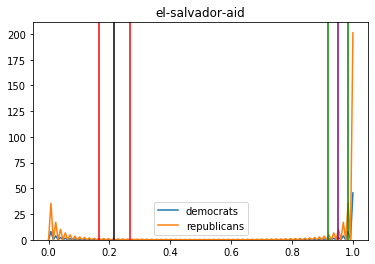

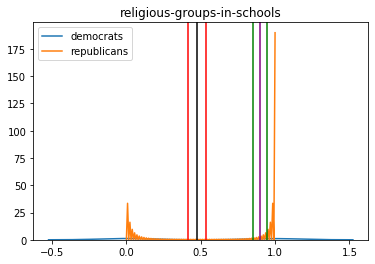

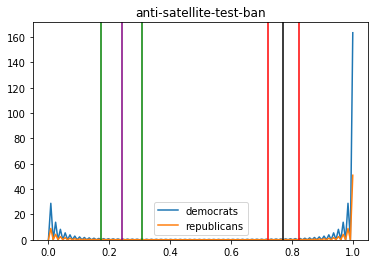

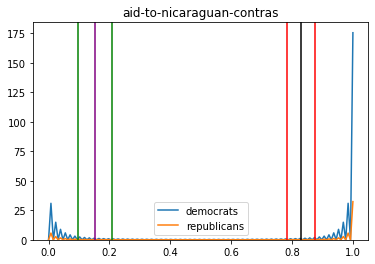

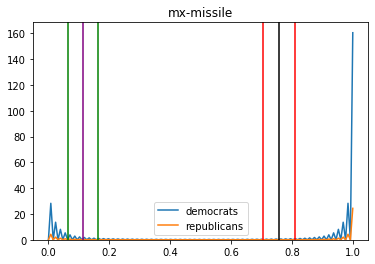

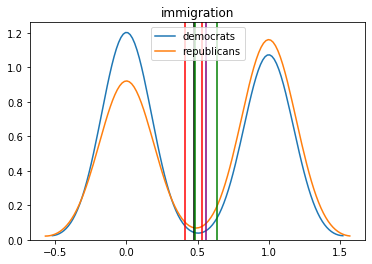

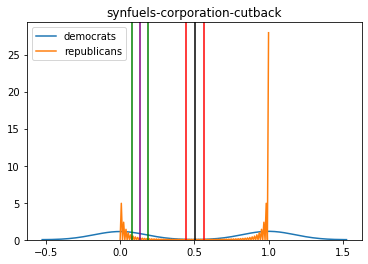

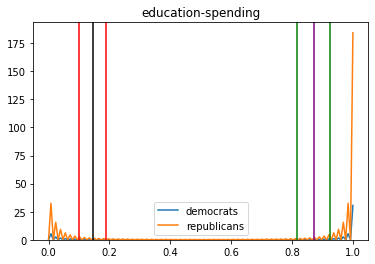

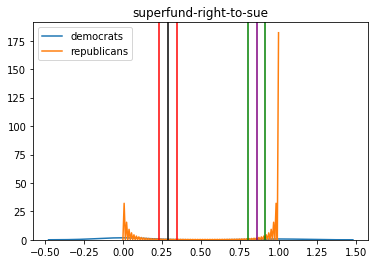

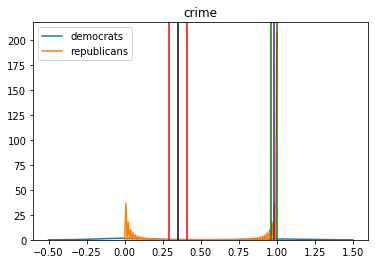

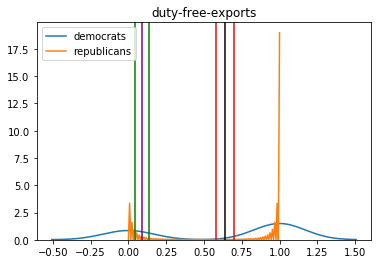

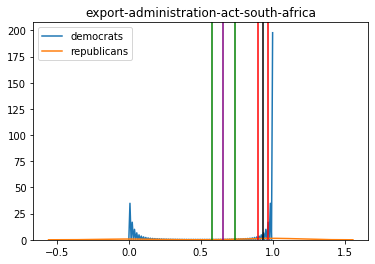

In [19]:
# try all the columns comparing democrats to republicans
def graph_this_column(graph_column):
  graph_data_dems = democrats[graph_column][~democrats[graph_column].isna()]
  graph_data_reps = republicans[graph_column][~republicans[graph_column].isna()]

  # get confidence interval
  graph_dem_mean, graph_dem_lower_bound, graph_dem_upper_bound = confidence_interval(graph_data_dems, 0.95)
  graph_rep_mean, graph_rep_lower_bound, graph_rep_upper_bound = confidence_interval(graph_data_reps, 0.95)

  graph_data_dems.name = 'democrats'
  graph_data_reps.name = 'republicans'

  # graph it
  sns.kdeplot(graph_data_dems).set_title(column)
  sns.kdeplot(graph_data_reps)
  plt.axvline(graph_dem_lower_bound, color='red')
  plt.axvline(graph_dem_mean, color='black')
  plt.axvline(graph_dem_upper_bound, color='red')
  plt.axvline(graph_rep_lower_bound, color='green')
  plt.axvline(graph_rep_mean, color='purple')
  plt.axvline(graph_rep_upper_bound, color='green')
  plt.show()

for column in house_votes_columns:
  if column == 'party':
    continue
  #print(column)
  graph_this_column(column)
# no ideaa how to choose a graph that explains what is going on

### 3. Interpret the confidence interval - what does it tell you about the data and its distribution?

gonna test democrats supported immigration bill more than republicans
- null hypothesis: democrat support for immigration bill = republican support for immigration bill
- alternate hypothesis: democrat support for immigration bill is different than republican support for immigration bill
- confidence level: 95%

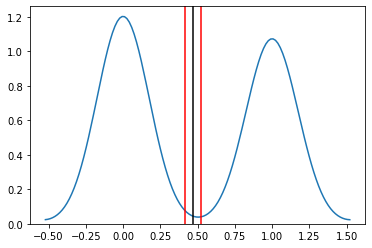

95% confidence interval: (0.525018096837778, 0.4179476826299025)
mean: 0.4714828897338403
t-statistic: -1.7359117329695164
p-value: 0.08330248490425282


In [20]:
interpret_column = 'immigration'
interpret_data_rep = republicans[interpret_column][~republicans[interpret_column].isna()]
interpret_data_dem = democrats[interpret_column][~democrats[interpret_column].isna()]

interpret_data = np.array(interpret_data_dem)
interpret_mean = np.mean(interpret_data)
interpret_n = len(interpret_data)
interpret_std_error = np.std(interpret_data, ddof=1) / np.sqrt(interpret_n)
interpret_result = stats.ttest_ind(interpret_data_dem, interpret_data_rep, nan_policy='omit')
interpret_margin_of_error = interpret_result.statistic * interpret_std_error
interpret_lower_bound = interpret_mean - interpret_margin_of_error
interpret_upper_bound = interpret_mean + interpret_margin_of_error

sns.kdeplot(interpret_data)
plt.axvline(interpret_lower_bound, color='red')
plt.axvline(interpret_mean, color='black')
plt.axvline(interpret_upper_bound, color='red')
plt.show()

print('95% confidence interval:', (interpret_lower_bound, interpret_upper_bound))
print('mean:', interpret_mean)
print('t-statistic:', interpret_result.statistic)
print('p-value:', interpret_result.pvalue)


- t-statistic: -1.7359...
- p-value: 0.08333...
- conclusion: mean falls within the upper and lower bounds of the confidence interval, so i fail to reject the null hypothesis and suggest that the alternate hypothesis - that support for the immigration bill differed between democrats and republicans - is correct. the negative t-value shows that the democrats had less support for the bill than the republicans

## Chi-squared

Take a dataset that we have used in the past in class that has categorical variables. Pick two of those categorical variables and run a chi-squared tests on that data

using flags data set from https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data

In [21]:
flag_data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data'
flags_column_headers = ['name', 'landmass', 'zone', 'area', 'population', 'language', 
                  'religion', 'bars', 'stripes', 'colours', 'red', 'green', 
                  'blue', 'gold', 'white', 'black', 'orange', 'mainhue', 
                  'circles', 'crosses', 'saltires', 'quarters', 'sunstars', 
                  'crescent', 'triangle', 'icon', 'animate', 'text', 'topleft', 
                  'botright']
flags = pd.read_csv(flag_data_url, header=None, names=flags_column_headers)
print(flags.shape)
flags

(194, 30)


,name,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,1,1,0,1,1,1,0,green,0,0,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,1,0,0,1,0,1,0,red,0,0,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,1,1,0,0,1,0,0,green,0,0,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,1,0,1,1,1,0,1,blue,0,0,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,1,0,1,1,0,0,0,gold,0,0,0,0,0,0,0,0,0,0,blue,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Western-Samoa,6,3,3,0,1,1,0,0,3,1,0,1,0,1,0,0,red,0,0,0,1,5,0,0,0,0,0,blue,red
190,Yugoslavia,3,1,256,22,6,6,0,3,4,1,0,1,1,1,0,0,red,0,0,0,0,1,0,0,0,0,0,blue,red
191,Zaire,4,2,905,28,10,5,0,0,4,1,1,0,1,0,0,1,green,1,0,0,0,0,0,0,1,1,0,green,green
192,Zambia,4,2,753,6,10,5,3,0,4,1,1,0,0,0,1,1,green,0,0,0,0,0,0,0,0,1,0,green,brown


find out about some of the columns

In [22]:
flags.describe()

,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,3.572165,2.211340,700.046392,23.268041,5.340206,2.190722,0.453608,1.551546,3.463918,0.788660,0.469072,0.510309,0.469072,0.752577,0.268041,0.134021,0.170103,0.149485,0.092784,0.149485,1.386598,0.056701,0.139175,0.252577,0.201031,0.082474
std,1.553018,1.308274,2170.927932,91.934085,3.496517,2.061167,1.038339,2.328005,1.300154,0.409315,0.500334,0.501187,0.500334,0.432631,0.444085,0.341556,0.463075,0.385387,0.290879,0.435860,4.396186,0.231869,0.347025,0.435615,0.401808,0.275798
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,9.000000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,111.000000,4.000000,6.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,471.250000,14.000000,9.000000,4.000000,0.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.750000,0.000000,0.000000
max,6.000000,4.000000,22402.000000,1008.000000,10.000000,7.000000,5.000000,14.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000,1.000000,4.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
flags.describe(exclude='number')

,name,mainhue,topleft,botright
count,194,194,194,194
unique,194,8,7,8
top,Venezuela,red,red,red
freq,1,71,56,69


In [24]:
for column in flags.columns:
  print(column, sorted(flags[column].unique()))

name ['Afghanistan', 'Albania', 'Algeria', 'American-Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antigua-Barbuda', 'Argentina', 'Argentine', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'British-Virgin-Isles', 'Brunei', 'Bulgaria', 'Burkina', 'Burma', 'Burundi', 'Cameroon', 'Canada', 'Cape-Verde-Islands', 'Cayman-Islands', 'Central-African-Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comorro-Islands', 'Congo', 'Cook-Islands', 'Costa-Rica', 'Cuba', 'Cyprus', 'Czechoslovakia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican-Republic', 'Ecuador', 'Egypt', 'El-Salvador', 'Equatorial-Guinea', 'Ethiopia', 'Faeroes', 'Falklands-Malvinas', 'Fiji', 'Finland', 'France', 'French-Guiana', 'French-Polynesia', 'Gabon', 'Gambia', 'Germany-DDR', 'Germany-FRG', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras'

In [0]:
religions = {0:'Catholic', 1:'Other Christian', 2:'Muslim', 3:'Buddhist', 4:'Hindu', 5:'Ethnic', 6:'Marxist', 7:'Others'}
languages = {1:'English', 2:'Spanish', 3:'French', 4:'German', 5:'Slavic', 6:'Other Indo-European', 7:'Chinese', 8:'Arabic', 9:'Japanese/Turkish/Finnish/Magyar', 10:'Others'}
landmasses = {1:'N.America', 2:'S.America', 3:'Europe', 4:'Africa', 5:'Asia', 6:'Oceania'}
zones = {1:'NE', 2:'SE', 3:'SW', 4:'NW'}

In [26]:
flags['religion'] = flags['religion'].map(lambda x: religions[x])
flags['language'] = flags['language'].map(lambda x: languages[x])
flags['landmass'] = flags['landmass'].map(lambda x: landmasses[x])
flags['zone'] = flags['zone'].map(lambda x: zones[x])
flags

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,Asia,NE,648,16,Others,Muslim,0,3,5,1,1,0,1,1,1,0,green,0,0,0,0,1,0,0,1,0,0,black,green
1,Albania,Europe,NE,29,3,Other Indo-European,Marxist,0,0,3,1,0,0,1,0,1,0,red,0,0,0,0,1,0,0,0,1,0,red,red
2,Algeria,Africa,NE,2388,20,Arabic,Muslim,2,0,3,1,1,0,0,1,0,0,green,0,0,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,Oceania,SW,0,0,English,Other Christian,0,0,5,1,0,1,1,1,0,1,blue,0,0,0,0,0,0,1,1,1,0,blue,red
4,Andorra,Europe,NE,0,0,Other Indo-European,Catholic,3,0,3,1,0,1,1,0,0,0,gold,0,0,0,0,0,0,0,0,0,0,blue,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Western-Samoa,Oceania,SW,3,0,English,Other Christian,0,0,3,1,0,1,0,1,0,0,red,0,0,0,1,5,0,0,0,0,0,blue,red
190,Yugoslavia,Europe,NE,256,22,Other Indo-European,Marxist,0,3,4,1,0,1,1,1,0,0,red,0,0,0,0,1,0,0,0,0,0,blue,red
191,Zaire,Africa,SE,905,28,Others,Ethnic,0,0,4,1,1,0,1,0,0,1,green,1,0,0,0,0,0,0,1,1,0,green,green
192,Zambia,Africa,SE,753,6,Others,Ethnic,3,0,4,1,1,0,0,0,1,1,green,0,0,0,0,0,0,0,0,1,0,green,brown


In [27]:
flags.isnull().sum()

name          0
landmass      0
zone          0
area          0
population    0
language      0
religion      0
bars          0
stripes       0
colours       0
red           0
green         0
blue          0
gold          0
white         0
black         0
orange        0
mainhue       0
circles       0
crosses       0
saltires      0
quarters      0
sunstars      0
crescent      0
triangle      0
icon          0
animate       0
text          0
topleft       0
botright      0
dtype: int64

In [28]:
for column in flags.columns:
  print(column, sorted(flags[column].unique()))

name ['Afghanistan', 'Albania', 'Algeria', 'American-Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antigua-Barbuda', 'Argentina', 'Argentine', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'British-Virgin-Isles', 'Brunei', 'Bulgaria', 'Burkina', 'Burma', 'Burundi', 'Cameroon', 'Canada', 'Cape-Verde-Islands', 'Cayman-Islands', 'Central-African-Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comorro-Islands', 'Congo', 'Cook-Islands', 'Costa-Rica', 'Cuba', 'Cyprus', 'Czechoslovakia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican-Republic', 'Ecuador', 'Egypt', 'El-Salvador', 'Equatorial-Guinea', 'Ethiopia', 'Faeroes', 'Falklands-Malvinas', 'Fiji', 'Finland', 'France', 'French-Guiana', 'French-Polynesia', 'Gabon', 'Gambia', 'Germany-DDR', 'Germany-FRG', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras'

going to work with mainhue by zone

In [29]:
pd.crosstab(flags['mainhue'], flags['zone'], margins=True)

zone,NE,NW,SE,SW,All
mainhue,,,,,
black,3,1,1,0,5
blue,10,16,8,6,40
brown,2,0,0,0,2
gold,10,6,1,2,19
green,14,9,7,1,31
orange,3,0,1,0,4
red,38,16,11,6,71
white,11,10,0,1,22
All,91,58,29,16,194


### by hand using numpy

In [0]:
chi2_numpy_table = pd.crosstab(flags['mainhue'], flags['zone'], margins=True)
chi2_numpy_observed = pd.crosstab(flags['mainhue'], flags['zone'])

In [31]:
# row sums with observed dataframe (no totals column)
# row_sums = chi2_numpy_observed.sum(axis=1).values

# row sums with margin-ed dataframe (has totals column)
row_sums = chi2_numpy_table['All'][:-1].values
row_sums

array([ 5, 40,  2, 19, 31,  4, 71, 22])

In [32]:
chi2_numpy_observed.sum().values

array([91, 58, 29, 16])

In [33]:
# column sums with observed dataframe (no totals row)
# col_sums = chi2_numpy_observed.sum().values

# column sums with margin-ed dataframe (has totals row)
col_sums = chi2_numpy_table.loc['All'][:-1].values
col_sums

array([91, 58, 29, 16])

In [34]:
# total from dataframe shape
# total = flags.shape[0]

total = row_sums.sum() if row_sums.sum() == col_sums.sum() else None
total

194

**build expected table**

$expected_{i,j} =\frac{(row_{i} \text{total})(column_{j} \text{total}) }{(\text{total observations})}$

In [35]:
expected = []
for row_sum in row_sums:
  new_row = []
  for col_sum in col_sums:
    new_row.append(row_sum * col_sum / total)
  expected.append(new_row)
expected 

[[2.345360824742268,
  1.4948453608247423,
  0.7474226804123711,
  0.41237113402061853],
 [18.762886597938145,
  11.958762886597938,
  5.979381443298969,
  3.2989690721649483],
 [0.9381443298969072,
  0.5979381443298969,
  0.29896907216494845,
  0.16494845360824742],
 [8.912371134020619,
  5.680412371134021,
  2.8402061855670104,
  1.5670103092783505],
 [14.541237113402062, 9.268041237113403, 4.634020618556701, 2.556701030927835],
 [1.8762886597938144,
  1.1958762886597938,
  0.5979381443298969,
  0.32989690721649484],
 [33.3041237113402, 21.22680412371134, 10.61340206185567, 5.855670103092783],
 [10.31958762886598, 6.577319587628866, 3.288659793814433, 1.8144329896907216]]

In [36]:
chi2_numpy_expected = pd.DataFrame(expected, index=chi2_numpy_observed.index, columns=chi2_numpy_observed.columns)
chi2_numpy_expected

zone,NE,NW,SE,SW
mainhue,,,,
black,2.345361,1.494845,0.747423,0.412371
blue,18.762887,11.958763,5.979381,3.298969
brown,0.938144,0.597938,0.298969,0.164948
gold,8.912371,5.680412,2.840206,1.567010
green,14.541237,9.268041,4.634021,2.556701
orange,1.876289,1.195876,0.597938,0.329897
red,33.304124,21.226804,10.613402,5.855670
white,10.319588,6.577320,3.288660,1.814433


In [37]:
print('expected shape:', chi2_numpy_expected.shape)
print('observed shape:', chi2_numpy_observed.shape)

expected shape: (8, 4)
observed shape: (8, 4)


**Chi-squared formula**

$\chi^2 = \sum \frac{(observed_{i}-expected_{i})^2}{(expected_{i})}$

In [38]:
# math with pandas dataframes
chi_squared = (((chi2_numpy_observed - chi2_numpy_expected) ** 2) / chi2_numpy_expected).sum().sum()
chi_squared

25.02294976765332

In [39]:
# math with pandas dataframe to numpy array
(((chi2_numpy_observed - chi2_numpy_expected) ** 2) / chi2_numpy_expected).values.sum()

25.02294976765332

In [40]:
# math with numpy arrays
(((chi2_numpy_observed.values - chi2_numpy_expected.values) ** 2) / chi2_numpy_expected.values).sum()

25.02294976765332

In [41]:
# degrees of freedom for a chi-squared test
# degress_of_freedom = (chi2_numpy_expected.shape[0] - 1) * (chi2_numpy_expected.shape[1] - 1)

degrees_of_freedom = (len(chi2_numpy_observed.columns)-1) * (len(chi2_numpy_observed)-1)
degrees_of_freedom

21

In [42]:
print('chi-squared:', chi_squared)
print(f'degrees of freedom: {degrees_of_freedom:.2f}')
# according to: https://www.di-mgt.com.au/images/chisquare-menez-table.gif
print('p-valuefrom chart 1: > 0.1')
# according to: https://d2vlcm61l7u1fs.cloudfront.net/media%2Fcd0%2Fcd03c24d-456a-4119-9ee8-ad61f2927f6d%2FphpcfDity.png
print('p-value from chart 2: 0.1 < p-value < 0.9')

print('p-value from scipy stats library:', stats.distributions.chi2.sf(chi_squared, degrees_of_freedom))

chi-squared: 25.02294976765332
degrees of freedom: 21.00
p-valuefrom chart 1: > 0.1
p-value from chart 2: 0.1 < p-value < 0.9
p-value from scipy stats library: 0.2461714719283676


**^--BLOCKER---^**

how to determine if null hypothesis to to be rejected / dependence vs independence

### in one line using scipy

In [43]:
chi_squared_scipy, p_value_scipy, degrees_of_freedom_scipy, expected_scipy = stats.chi2_contingency(chi2_numpy_observed)

print(f'chi-squared: {chi_squared_scipy}')
print(f'p-value: {p_value_scipy}')
print(f'degrees of freedom: {degrees_of_freedom_scipy}')
print(f'expected:\n{expected_scipy}')
print()
print('expected_scipy as a dataframe:')
pd.DataFrame(expected_scipy, index=chi2_numpy_observed.index, columns=chi2_numpy_observed.columns)

chi-squared: 25.022949767653323
p-value: 0.24617147192836739
degrees of freedom: 21
expected:
[[ 2.34536082  1.49484536  0.74742268  0.41237113]
 [18.7628866  11.95876289  5.97938144  3.29896907]
 [ 0.93814433  0.59793814  0.29896907  0.16494845]
 [ 8.91237113  5.68041237  2.84020619  1.56701031]
 [14.54123711  9.26804124  4.63402062  2.55670103]
 [ 1.87628866  1.19587629  0.59793814  0.32989691]
 [33.30412371 21.22680412 10.61340206  5.8556701 ]
 [10.31958763  6.57731959  3.28865979  1.81443299]]

expected_scipy as a dataframe:


zone,NE,NW,SE,SW
mainhue,,,,
black,2.345361,1.494845,0.747423,0.412371
blue,18.762887,11.958763,5.979381,3.298969
brown,0.938144,0.597938,0.298969,0.164948
gold,8.912371,5.680412,2.840206,1.567010
green,14.541237,9.268041,4.634021,2.556701
orange,1.876289,1.195876,0.597938,0.329897
red,33.304124,21.226804,10.613402,5.855670
white,10.319588,6.577320,3.288660,1.814433


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)